$$
{\huge \text{Model selection bias: prediction and forecast}}
$$

$$
{\scriptsize \text{Massimo Pierini, 2025}}
$$

It is well known that model selection procedures invalidate classical inference on the parameters of the selected model (Berk 2010, 2013; Leeb 2005; Pötscher 1991).

The aim of this notebook is to provide a simple and fully reproducible simulation to verify whether the model selection bias can impact prediction/forecast also or not.

# INTRODUCTION

In this simple simulation, we'll experimentally verify that, even if a model selection procedure distorts the distribution of the estimators so that the classical inference cannot be safely applied anymore to the selected model, the prediction/forecast can be safely applied.

We'll use a modified version of the "Simulations of Model-Selection", section 4 of "Statistical Inference After Model Selection" (Berk 2010).

# DEFINITION

For this simulation, the full regression model takes the form of

\begin{equation}
y_i = \beta_0 + \beta_w w_i + \beta_x x_i + \beta_z z_i + \varepsilon_i
\end{equation}
where

\begin{equation}
\left\{
\begin{array}{l}
\beta_0 = 3.0
\\
\beta_w = 0.0
\\
\beta_x = 0.50
\\
\beta_z = 0.25
\end{array}
\right.
\end{equation}

and $\varepsilon_i \overset{iid}{\sim} N(0, \sigma_\varepsilon^2)$.

Because the parameter $\beta_w = 0$ in equation $(1)$, many would refer to a submodel that excluded $W$ as
the “correct” model. But equation $(1)$ is also correct as long at $\beta_w = 0$ is
allowed. Therefore, we will use the adjective “preferred” for the model with
$W$ excluded. The full model and the preferred model will generate the same
conditional expectations for the response. The smaller model is preferred
because it is simpler and uses up one less degree of freedom (Berk 2009).

All three predictors are drawn at random from a multivariate normal
distribution with null means.

The
variances and covariances are set as follows: 
$\sigma_\varepsilon^2 = 10.0$, 
$\sigma_w^2 = 5.0$, 
$\sigma_x^2 = 6.0$,
$\sigma_z^2 = 7.0$, 
$\sigma_{w,x} = 4.0$, 
$\sigma_{w,z} = 5.0$, 
and $\sigma_{x,z} = 5.0$,
therefore leading to the following covariance matrix $\Sigma$

\begin{equation}
\Sigma = 
\begin{bmatrix}
5 & 4 & 5
\\
4 & 6 & 5
\\
5 & 5 & 7
\end{bmatrix}
\end{equation}

The sample sizes will be 200. It will be splitted in two subsets, 150 to train the model and 50 to test it.

10,000 samples will be drawn, forward stepwise regression minimizing AIC applied to each, and sampling distributions will be constructed from the final models selected. Test RMSE, test Mean Absolute Error (MAE) and test Mean Absolute Percentage Errore (MAPE) will be plotted, where

\begin{equation}
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat y_i)^2 }
\end{equation}

\begin{equation}
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat y_i|
\end{equation}

\begin{equation}
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat y_i}{y_i} \right|
\end{equation}

# SIMULATIONS

First of all, let's make the needed imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import (
    root_mean_squared_error as RMSE,
    mean_absolute_error as MAE,
    mean_absolute_percentage_error as MAPE
)
from sklearn.model_selection import train_test_split

and define the "true" coefficients, variances, covariances, and sample size. We'll set a seed (`random_state`) to ensure reproducibility.

In [2]:
# true model coefficients
beta0 = 3.0
betaw = 0.0
betax = .50
betaz = .25
N = 200
# random errors distribution
epsilon = sps.norm(loc=0, scale=np.sqrt(10.0))
# predictors drawing from a multinormal distribution
X = sps.multivariate_normal(mean=[0, 0, 0], cov=[
    [ 5,  4,  5],
    [ 4,  6,  5],
    [ 5,  5,  7]
]).rvs(N, random_state=42)

Let's now draw a sample of $Y$ using model $(1)$ and take a look at a pairplot of the resulting data.

In [3]:
Y = beta0 + betaw*X[:,0] + betax*X[:,1] + betaz*X[:,2] + epsilon.rvs(N, random_state=1976)

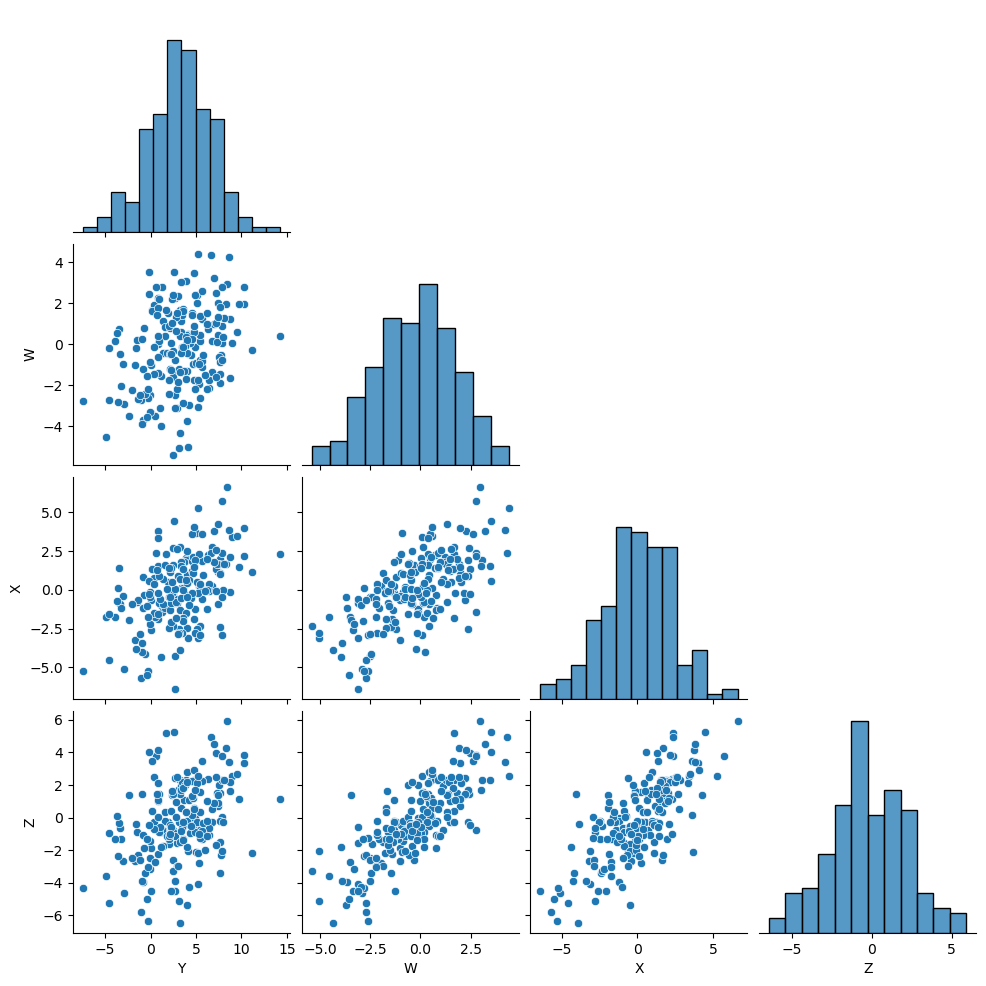

In [4]:
df = pd.DataFrame({
        "Y":Y, "W": X[:,0], "X": X[:,1], "Z": X[:,2]
    })
sns.pairplot(df, corner=True)
plt.show()

In [5]:
sm.OLS.from_formula("Y ~ 1", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 28 Sep 2025   Prob (F-statistic):                nan
Time:                        17:45:46   Log-Likelihood:                -531.73
No. Observations:                 200   AIC:                             1065.
Df Residuals:                     199   BIC:                             1069.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2597      0.245     13.311      0.000       2.777       3.743
==============================================================================
Omnibus:                        1.118   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                0.816
Skew:                          -0.134   Prob(JB):                        0.665
Kurtosis:                       3.162   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's now define the forward stepwise selection procedure (modified from https://ujangriswanto08.medium.com/mastering-stepwise-linear-regression-in-python-from-theory-to-practice-d7293d635240).

In [123]:
def forward_selection(X, y, verbose=False):
    selected_features = []
    remaining_features = list(X.columns)
    model = sm.OLS.from_formula("Y ~ 1", data=pd.DataFrame({"Y": y})).fit() # null model, intercept only
    best_aic = model.aic

    if verbose: print("------------ START -------------")
    while remaining_features:
        if verbose: print(f"Selected features:  {selected_features}")
        if verbose: print(f"Remaining features: {remaining_features}")
        aic_with_candidates = []
        
        for candidate in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [candidate]])).fit()
            if verbose: print(f"  AIC of {candidate}: {model.aic}")
            aic_with_candidates.append((model.aic, candidate))
        
        aic_with_candidates.sort()  # Sort by AIC
        best_new_aic, best_candidate = aic_with_candidates[0]
        if verbose: print(f"    Best: {best_candidate} (AIC: {best_new_aic})")

        if best_new_aic < best_aic:
            if verbose: print("    BEST NEW AIC less than PREVIOUS")
            best_aic = best_new_aic
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
        else:
            if verbose: print("    BEST NEW AIC greater than PREVIOUS")
            break
    if verbose: print(f"SELECTED MODEL: {selected_features}")
    if verbose: print("------------ END -------------")
    return selected_features

Let's now start the simulation, collecting: 

- whether the predictor has been included in the model
- the test RMSE for each selected model and for the preferred model
- the test MAE for each selected model and for the preferred model
- the test MAPE for each selected model and for the preferred model

We'll set a seed for each drawing and train-test split to ensure reproducibility.

Notice we do not (and we do not need nor want to) take other samples of the predictors: the predictors are not random variables, they're fixed and known without errors. $\pmb Y$ is a random variable, because of the identically and independently distributed random errors $\pmb \varepsilon$.

In [125]:
# samples numnber
rep = 10000
# init results
models = {
    "W": [],
    "X": [],
    "Z": [],
    "RMSE": [],
    "MAE": [],
    "MAPE": []
}
pref_model = {
    "RMSE": [],
    "MAE": [],
    "MAPE": []
}
# simulation
for i in tqdm(range(rep)):
    # draw a sample of Y given equation (1)
    Y = beta0 + betaw*X[:,0] + betax*X[:,1] + betaz*X[:,2] + epsilon.rvs(N, random_state=rep+i)
    df = pd.DataFrame({
        "Y":Y, "W": X[:,0], "X": X[:,1], "Z": X[:,2]
    })
    # split the data
    df_train, df_test = train_test_split(df, train_size=.75, random_state=i)
    x_train = df_train.drop('Y', axis=1)  # Features
    y_train = df_train['Y']               # Target variable
    # forward stepwise model selection
    selected_features = forward_selection(x_train, y_train)
    if len(selected_features):
        mod = sm.OLS.from_formula("Y ~ " + " + ".join(selected_features), data=df_train).fit()
    else:
        mod = sm.OLS.from_formula("Y ~ 1", data=df_train).fit()
    y_pred = mod.predict(df_test)
    _rmse = RMSE(df_test["Y"], y_pred)
    _mae = MAE(df_test["Y"], y_pred)
    _mape = MAPE(df_test["Y"], y_pred)
    # collect t-test statistics and R-squared
    models["RMSE"].append(_rmse)
    models["MAE"].append(_mae)
    models["MAPE"].append(_mape)
    models["W"].append("W" in selected_features)
    models["X"].append("X" in selected_features)
    models["Z"].append("Z" in selected_features)
    # preferred model
    mod = sm.OLS.from_formula("Y ~ X + Z", data=df_train).fit()
    y_pred = mod.predict(df_test)
    _rmse = RMSE(df_test["Y"], y_pred)
    _mae = MAE(df_test["Y"], y_pred)
    _mape = MAPE(df_test["Y"], y_pred)
    # collect t-test statistics and R-squared
    pref_model["RMSE"].append(_rmse)
    pref_model["MAE"].append(_mae)
    pref_model["MAPE"].append(_mape)

  0%|          | 0/10000 [00:00<?, ?it/s]

# RESULTS

Let's define `DataFrame`s of the results.

In [126]:
DF = pd.DataFrame(models)
DF

,W,X,Z,RMSE,MAE,MAPE
0,False,True,False,3.184058,2.607267,3.287251
1,True,True,False,3.373206,2.604563,1.680066
2,False,True,False,3.293143,2.589978,2.490769
3,False,True,False,3.140603,2.643385,2.030348
4,True,True,False,3.229751,2.823205,1.369933
...,...,...,...,...,...,...
9995,False,True,False,3.328301,2.474447,1.001025
9996,False,True,False,2.957951,2.380563,3.309917
9997,False,True,False,2.848367,2.290006,5.304035
9998,False,True,False,2.856857,2.353297,1.615061


In [127]:
PR = pd.DataFrame(pref_model)
PR

,RMSE,MAE,MAPE
0,3.144770,2.566421,3.202121
1,3.310611,2.539186,1.669615
2,3.296691,2.594934,2.495629
3,3.101057,2.625020,1.925105
4,3.189799,2.747952,1.326706
...,...,...,...
9995,3.277428,2.440443,1.029916
9996,2.862258,2.316565,3.273672
9997,2.835011,2.290816,5.064600
9998,2.861305,2.364731,1.644218


Let's now compute the absolute and relative frequencies of the 8 possible models, selected by the forward stepwise procedure.

In [128]:
perc_selection = pd.DataFrame({
    "null": [DF[(~DF.W)&(~DF.X)&(~DF.Z)].index.size],
    "W": [DF[(DF.W)&(~DF.X)&(~DF.Z)].index.size],
    "X": [DF[(~DF.W)&(DF.X)&(~DF.Z)].index.size],
    "Z": [DF[(~DF.W)&(~DF.X)&(DF.Z)].index.size],
    "WX": [DF[(DF.W)&(DF.X)&(~DF.Z)].index.size],
    "WZ": [DF[(DF.W)&(~DF.X)&(DF.Z)].index.size],
    "XZ": [DF[(~DF.W)&(DF.X)&(DF.Z)].index.size],
    "WXZ": [DF[(DF.W)&(DF.X)&(DF.Z)].index.size]
})
perc_selection.style.hide(axis="index").set_caption("SELECTED MODELS ABSOLUTE FREQUENCIES")

null,W,X,Z,WX,WZ,XZ,WXZ
0,19,3736,542,1252,86,3810,555


In [129]:
perc_selection = pd.DataFrame({
    "null": [DF[(~DF.W)&(~DF.X)&(~DF.Z)].index.size/rep],
    "W": [DF[(DF.W)&(~DF.X)&(~DF.Z)].index.size/rep],
    "X": [DF[(~DF.W)&(DF.X)&(~DF.Z)].index.size/rep],
    "Z": [DF[(~DF.W)&(~DF.X)&(DF.Z)].index.size/rep],
    "WX": [DF[(DF.W)&(DF.X)&(~DF.Z)].index.size/rep],
    "WZ": [DF[(DF.W)&(~DF.X)&(DF.Z)].index.size/rep],
    "XZ": [DF[(~DF.W)&(DF.X)&(DF.Z)].index.size/rep],
    "WXZ": [DF[(DF.W)&(DF.X)&(DF.Z)].index.size/rep]
})
perc_selection.style.hide(axis="index").format('{:.2%}').set_caption("SELECTED MODELS RELATIVE FREQUENCIES")

null,W,X,Z,WX,WZ,XZ,WXZ
0.00%,0.19%,37.36%,5.42%,12.52%,0.86%,38.10%,5.55%


We see that

- the preferred model has been selected approx. $38\%$ of the times

- the null model has never been selected

- the full model and a model with $Z$ only have been selected approx. $6\%$ of the times

- respectively, approx. $37\%$ and $13\%$ of the times, models with $X$ and with both $X$ and $W$ have been selected

- other models (with $W$, with $Z$, and with $WZ$) have been selected less than $1\%$ of times

Let's take a look at the relative frequencies of each predictor having been included in the selected model.

In [130]:
perc_predictor = pd.DataFrame({
    "W": [DF[(DF.W)].index.size/rep],
    "X": [DF[(DF.X)].index.size/rep],
    "Z": [DF[(DF.Z)].index.size/rep]
})
perc_predictor.style.hide(axis="index").format('{:.2%}').set_caption("INCLUDED PREDICTORS RELATIVE FREQUENCIES")

W,X,Z
19.12%,93.53%,49.93%


Notice that the predictor $W$ has been included a non-zero percentage of the times (approx. $20\%$...!), even if we know that the "true" value of $\beta_w$ is null.

Let's now plot the distributions (KDE) of the parameters' estimates for both the preferred and the selected models.

For the selected models, the distributions for each predictor's parameter are conditional on the predictor having been included in the selected model.

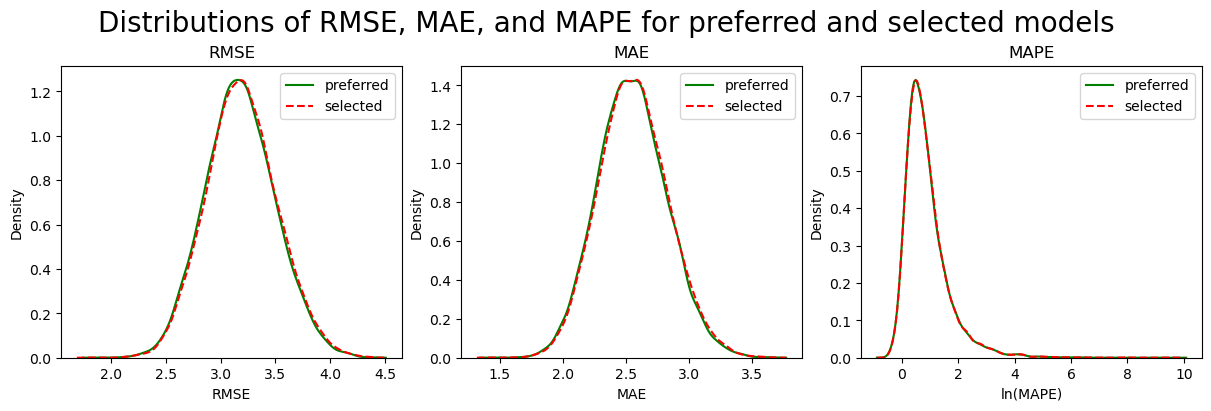

In [131]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), layout="constrained")

sns.kdeplot(PR.RMSE, label="preferred", color="g", ax=ax[0])
sns.kdeplot(DF.RMSE, label="selected", color="r", ls="--", ax=ax[0])
ax[0].legend()
ax[0].set_title("RMSE")

sns.kdeplot(PR.MAE, label="preferred", color="g", ax=ax[1])
sns.kdeplot(DF.MAE, label="selected", color="r", ls="--", ax=ax[1])
ax[1].legend()
ax[1].set_title("MAE")

sns.kdeplot(np.log(PR.MAPE), label="preferred", color="g", ax=ax[2])
sns.kdeplot(np.log(DF.MAPE), label="selected", color="r", ls="--", ax=ax[2])
ax[2].legend()
ax[2].set_xlabel("ln(MAPE)")
ax[2].set_title("MAPE")
# ax[2].set_xscale("log")

fig.suptitle("Distributions of RMSE, MAE, and MAPE for preferred and selected models", fontsize=20)

plt.show()

We notice that all distribution seem to be quite similar.

To perform the KS test, we'll first calculate the optimal sample size for a significance level of $5\%$ and a desired power of $80\%$. Then, since the KS test is too "strict", we'll define that two samples are not "too different" if their KS test statistic is not greater than $5\%$.

In [132]:
def optimal_ks_size(df1, df2, col):
    KS = sps.ks_2samp(df1[col].dropna(), df2[col].dropna(), nan_policy="raise", alternative="two-sided")
    x_str = KS.statistic_location
    p = df1[df1[col]<=x_str].index.size/df1.index.size
    q = df2[df2[col]<=x_str].index.size/df2.index.size
    S = p*(1-p) + q*(1-q)
    delta = KS.statistic
    c = 1.358 # for alpha=.05
    z = .8416 # for gamma=.80
    n_opt = int(np.round(((z*np.sqrt(S) + c*np.sqrt(2))/delta)**2))
    return n_opt

In [133]:
n_RMSE = optimal_ks_size(DF, PR, "RMSE")
n_RMSE

15355

  0%|          | 0/1000 [00:00<?, ?it/s]

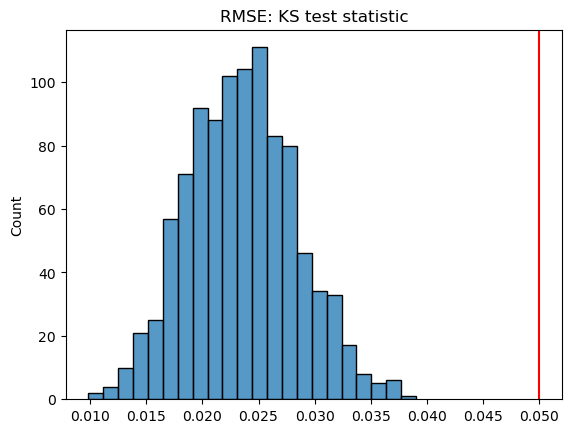

In [142]:
KSs = []
subsize = min(n_RMSE, DF.index.size)
for i in tqdm(range(1000)):
    _df = DF[DF.index.isin(np.random.choice(DF.index, size=subsize, replace=True))]
    _pr = PR[PR.index.isin(np.random.choice(PR.index, size=subsize, replace=True))]
    ks = sps.ks_2samp(_df.RMSE.dropna(), _pr.RMSE.dropna(), nan_policy="raise", alternative="two-sided")
    KSs.append(ks.statistic)
KSs = np.array(KSs)
sns.histplot(KSs)
plt.axvline(.05, color="r")
plt.title("RMSE: KS test statistic")
plt.show()

In [135]:
n_MAE = optimal_ks_size(DF, PR, "MAE")
n_MAE

19304

  0%|          | 0/1000 [00:00<?, ?it/s]

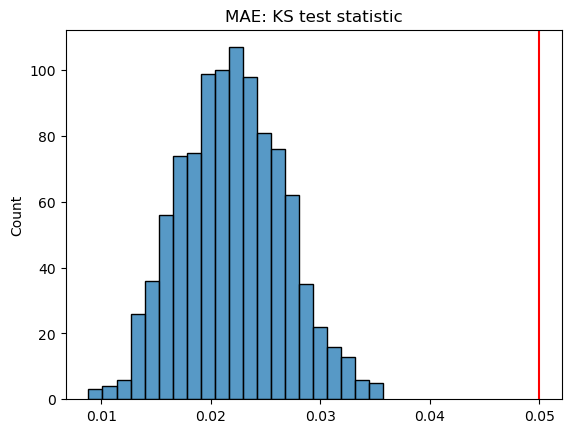

In [140]:
KSs = []
subsize = min(n_MAE, DF.index.size)
for i in tqdm(range(1000)):
    _df = DF[DF.index.isin(np.random.choice(DF.index, size=subsize, replace=True))]
    _pr = PR[PR.index.isin(np.random.choice(PR.index, size=subsize, replace=True))]
    ks = sps.ks_2samp(_df.MAE.dropna(), _pr.MAE.dropna(), nan_policy="raise", alternative="two-sided")
    KSs.append(ks.statistic)
KSs = np.array(KSs)
sns.histplot(KSs)
plt.axvline(.05, color="r")
plt.title("MAE: KS test statistic")
plt.show()

In [137]:
n_MAPE = optimal_ks_size(DF, PR, "MAPE")
n_MAPE

210335

  0%|          | 0/1000 [00:00<?, ?it/s]

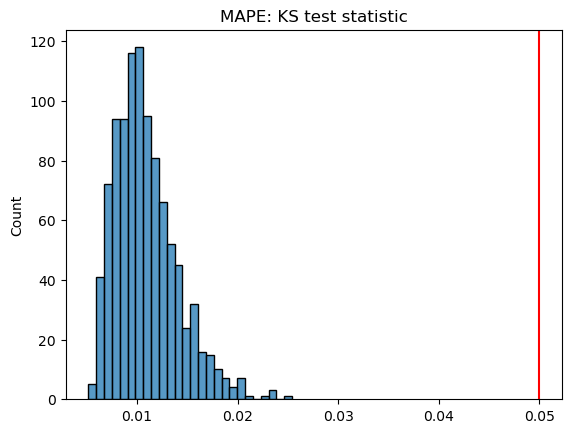

In [141]:
KSs = []
subsize = min(n_MAPE, DF.index.size)
for i in tqdm(range(1000)):
    _df = DF[DF.index.isin(np.random.choice(DF.index, size=subsize, replace=True))]
    _pr = PR[PR.index.isin(np.random.choice(PR.index, size=subsize, replace=True))]
    ks = sps.ks_2samp(_df.MAPE.dropna(), _pr.MAPE.dropna(), nan_policy="raise", alternative="two-sided")
    KSs.append(ks.statistic)
KSs = np.array(KSs)
sns.histplot(KSs)
plt.axvline(.05, color="r")
plt.title("MAPE: KS test statistic")
plt.show()

We must conclude that, for all three goodness of prediction indices, the two samples are not "enough" different.

# CONCLUSIONS

As pointed out by Berk (2010) and many other Authors who have deeply studied the model selection bias, we have experimentally verified that the model selection procedure distorts the estimators' distributions, invalidating the classical inference on the selected model.

This happens because, as a result of the model selection procedure, the model itself is not "fixed" anymore but becomes a random variable itself (Berk 2013), potentially having dramatic effects on the estimators' distributions, as in the simulation we performed.

This simple simulation, didn't fail to verify that prediction/forecast can be safely applied despite the known estimators distortions induced by the model selection procedure.

# ESSENTIAL BIBLIOGRAPHY

Berk, R., Brown, L., & Zhao, L. (2010). Statistical inference after model selection. _Journal of Quantitative Criminology, 26(2)_, 217-236.

Berk, R., Brown, L., Buja, A., Zhang, K., & Zhao, L. (2013). Valid post-selection inference. _The Annals of Statistics_, 802-837.

Leeb, H., & Pötscher, B. M. (2005). Model selection and inference: Facts and fiction. _Econometric Theory, 21(1)_, 21-59.

Pötscher, B. M. (1991). Effects of model selection on inference. _Econometric Theory, 7(2)_, 163-185.

Hyndman, R.J., & Athanasopoulos, G. (2021) _Forecasting: principles and practice_, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Accessed on 2025-09-28.

Many other papers, even more recent, can be found in the literature.